# ResNet50 Model

Before running this notebook, please make sure to run the `AugmentAndSplit.ipynb` notebook beforehand.

## This notebook has the following sections:

1. Prerequisites

2. Grid Search

3. Training using the Best Hyperparameters

4. Model Evaluation using a Confusion Matrix

5. Model Evaluation using K-Fold Cross Validation

# Section 1 - Prerequisites

In this section, we will import all the necessary libraries to run the notebook, define constants and invariants, and define the architecture of our model.

In [1]:
"""
Log dependency versions for reproducibility
"""
import sys
print("python",  sys.version)
import matplotlib
print("matplotlib", matplotlib.__version__)
import pandas
print("pandas", pandas.__version__)
import numpy
print("numpy", numpy.__version__)
import keras
print("keras", keras.__version__)
import tensorflow
print("tensorflow", tensorflow.__version__)
import sklearn
print("sklearn", sklearn.__version__)
import scikeras
print("scikeras", scikeras.__version__)

python 3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
matplotlib 3.10.0
pandas 2.2.3
numpy 1.26.4
keras 3.9.0
tensorflow 2.15.0
sklearn 1.3.1
scikeras 0.13.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

# Loading Datasets and Models
from keras.utils import image_dataset_from_directory
from keras.saving import load_model

# Saving Results
import os
import json

# Building our Model
from keras import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.applications.resnet50 import ResNet50, preprocess_input # ResNet50

# Compiling our Model
from keras.optimizers import SGD, Adam, RMSprop

# Grid Search
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# K-Fold
from sklearn.model_selection import KFold

In [3]:
"""
Constants and Invariant Parameters
"""
# Invariant parameters
BATCH_SIZE = 16
EPOCHS = 10 # Due to limited hardware, we will only compute up to 10 epochs for realistic runtime constraints
VALIDATION_SPLIT = 0.2
SEED = 42

# Model tuning and evaluation
GRID_SEARCH_ITERATIONS = 3 # Number of attempts per hyperparameter combination (the score of these attempts will be averaged)
K_FOLDS = 5

# Constants
IMAGE_SIZE = (150, 150)
OPTIMIZERS = {
    "Adam": Adam,
    "SGD": SGD,
    "RMSprop": RMSprop,
}

# File and directory management
INPUT_DIRECTORY = "training_and_validation_dataset"
TESTING_DIRECTORY = "testing_dataset"
MODEL_NAME = "ResNet50"

In [ ]:
"""
Define the model architecture
"""
resnet = ResNet50(
    input_shape=IMAGE_SIZE + tuple([3]), # (150, 150, 3)
    weights="imagenet",                  # Use pre-trained weights
    include_top=False,                   # Remove top layer to add our own layers
)

# Freeze the pre-trained weights
for layer in resnet.layers:
    layer.trainable = False

def create_model(optimizer="SGD", learning_rate=0.001):
    model = Sequential([
        resnet,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])

    optimizer = OPTIMIZERS[optimizer]

    model.compile(
        optimizer=optimizer(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Section 2 - Grid Search
In this section, we will perform grid search on our model to tune our chosen hyperparameters. The best hyperparameter configuration will be determined and saved into a .csv file.

In [ ]:
"""
Define hyperparameter grid
"""
# Use the model prefix for compatibility with the GridSearch API
param_grid = {
    "model__optimizer": ["Adam", "SGD", "RMSprop"],
    "model__learning_rate": [0.0001, 0.001, 0.01, 0.1],
}

In [11]:
"""
Load the training dataset
"""
training_dataset = image_dataset_from_directory(
    INPUT_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset="training",
    validation_split=VALIDATION_SPLIT,
    seed=SEED,
)
validation_dataset = image_dataset_from_directory(
    INPUT_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset="validation",
    validation_split=VALIDATION_SPLIT,
    seed=SEED,
)

# Apply ResNet50's image preprocessing
training_dataset = training_dataset.map(lambda x, y: (preprocess_input(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (preprocess_input(x), y))

Found 712 files belonging to 2 classes.
Using 570 files for training.
Found 712 files belonging to 2 classes.
Using 142 files for validation.


In [12]:
"""
Prepare the data to be compatible with the GridSearch API
"""

# Function to convert TF dataset to NumPy arrays
def dataset_to_numpy(dataset):
    all_images, all_labels = [], []
    for images, labels in dataset:
        all_images.append(images.numpy())  # Convert images to NumPy
        all_labels.append(labels.numpy())  # Convert labels to NumPy
    return np.vstack(all_images), np.hstack(all_labels)

# Convert datasets for GridSearch compatibility
training_images, training_labels = dataset_to_numpy(training_dataset)
validation_images, validation_labels = dataset_to_numpy(validation_dataset)

# Wrap model for GridSearch compatibility
model = KerasClassifier(model=create_model, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

In [14]:
"""
Perform Grid Search
"""
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=GRID_SEARCH_ITERATIONS
)
grid_result = grid.fit(
    training_images,
    training_labels,
    validation_data=(
        validation_images,
        validation_labels
    )
)

# Output best parameters
print(f"Best Params: {grid_result.best_params_}")
print(f"Best Score: {grid_result.best_score_}")

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - accuracy: 0.6233 - loss: 0.6927 - val_accuracy: 0.8732 - val_loss: 0.3496
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.8786 - loss: 0.3211 - val_accuracy: 0.8803 - val_loss: 0.2675
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9485 - loss: 0.1831 - val_accuracy: 0.8944 - val_loss: 0.2186
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9615 - loss: 0.1574 - val_accuracy: 0.9014 - val_loss: 0.2061
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9613 - loss: 0.1221 - val_accuracy: 0.9085 - val_loss: 0.1794
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9851 - loss: 0.1038 - val_accuracy: 0.9366 - val_loss: 0.1633
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9723 - loss: 0.1138 - val_accuracy: 0.9366 - val_loss: 0.1466
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9740 - loss: 0.0944 - val_accuracy: 0.

2025-03-22 07:20:45.662840: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - accuracy: 0.6246 - loss: 0.7180 - val_accuracy: 0.8803 - val_loss: 0.3725
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.8291 - loss: 0.3500 - val_accuracy: 0.8873 - val_loss: 0.2698
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9452 - loss: 0.1958 - val_accuracy: 0.9155 - val_loss: 0.2277
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9586 - loss: 0.1464 - val_accuracy: 0.9155 - val_loss: 0.2007
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9779 - loss: 0.1185 - val_accuracy: 0.9225 - val_loss: 0.1900
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9639 - loss: 0.1314 - val_accuracy: 0.9225 - val_loss: 0.1776
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9838 - loss: 0.0847 - val_accuracy: 0.9225 - val_loss: 0.1660
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy

2025-03-22 07:22:12.367424: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 409ms/step - accuracy: 0.3902 - loss: 0.9639 - val_accuracy: 0.4366 - val_loss: 0.7373
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.5018 - loss: 0.7995 - val_accuracy: 0.6268 - val_loss: 0.6632
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5075 - loss: 0.7531 - val_accuracy: 0.6972 - val_loss: 0.6284
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.6225 - loss: 0.7031 - val_accuracy: 0.6972 - val_loss: 0.6067
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.6471 - loss: 0.6423 - val_accuracy: 0.7042 - val_loss: 0.5900
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.6643 - loss: 0.6491 - val_accuracy: 0.7042 - val_loss: 0.5759
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.6699 - loss: 0.6324 - val_accuracy: 0.7042 - val_loss: 0.5631
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy

2025-03-22 07:23:13.585897: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 438ms/step - accuracy: 0.5693 - loss: 0.6904 - val_accuracy: 0.6408 - val_loss: 0.6728
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6441 - loss: 0.6372 - val_accuracy: 0.6549 - val_loss: 0.6534
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.6393 - loss: 0.6664 - val_accuracy: 0.6620 - val_loss: 0.6357
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.6611 - loss: 0.6390 - val_accuracy: 0.6620 - val_loss: 0.6190
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.6960 - loss: 0.5916 - val_accuracy: 0.6761 - val_loss: 0.6039
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.6682 - loss: 0.6068 - val_accuracy: 0.6761 - val_loss: 0.5883
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.6939 - loss: 0.5778 - val_accuracy: 0.6831 - val_loss: 0.5746
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.7137 - loss: 0.5356 - val_accuracy: 0.7113 - val

2025-03-22 07:24:38.081367: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 365ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 424ms/step - accuracy: 0.7650 - loss: 0.5398 - val_accuracy: 0.8944 - val_loss: 0.2847
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.8933 - loss: 0.2826 - val_accuracy: 0.8944 - val_loss: 0.2351
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9606 - loss: 0.1520 - val_accuracy: 0.9225 - val_loss: 0.2038
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9451 - loss: 0.1433 - val_accuracy: 0.9437 - val_loss: 0.1918
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9552 - loss: 0.1296 - val_accuracy: 0.9366 - val_loss: 0.1712
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9722 - loss: 0.1112 - val_accuracy: 0.9296 - val_loss: 0.1628
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9792 - loss: 0.0827 - val_accuracy: 0.9296 - val_loss: 0.1555
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy

2025-03-22 07:25:45.823074: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 462ms/step - accuracy: 0.6390 - loss: 0.8179 - val_accuracy: 0.8592 - val_loss: 0.3176
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.8671 - loss: 0.3218 - val_accuracy: 0.9155 - val_loss: 0.2430
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9298 - loss: 0.1993 - val_accuracy: 0.9085 - val_loss: 0.2194
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9373 - loss: 0.1767 - val_accuracy: 0.9155 - val_loss: 0.1939
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9480 - loss: 0.1414 - val_accuracy: 0.9296 - val_loss: 0.1689
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9630 - loss: 0.1331 - val_accuracy: 0.9225 - val_loss: 0.1626
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9746 - loss: 0.0896 - val_accuracy: 0.9296 - val_loss: 0.1556
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9860 - loss: 0.0677 - val_accuracy: 0.9296 - val

2025-03-22 07:27:12.215843: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 528ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 545ms/step - accuracy: 0.6971 - loss: 0.5816 - val_accuracy: 0.8732 - val_loss: 0.2787
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.9057 - loss: 0.2252 - val_accuracy: 0.9014 - val_loss: 0.2140
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.9462 - loss: 0.1648 - val_accuracy: 0.9225 - val_loss: 0.1966
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9503 - loss: 0.1256 - val_accuracy: 0.9296 - val_loss: 0.1709
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9722 - loss: 0.0790 - val_accuracy: 0.9366 - val_loss: 0.1551
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9848 - loss: 0.0869 - val_accuracy: 0.9577 - val_loss: 0.1364
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9726 - loss: 0.0792 - val_accuracy: 0.9366 - val_loss: 0.1336
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accurac

2025-03-22 07:28:15.610082: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 578ms/step - accuracy: 0.7603 - loss: 0.5170 - val_accuracy: 0.9014 - val_loss: 0.2513
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.9319 - loss: 0.1856 - val_accuracy: 0.9014 - val_loss: 0.2028
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9537 - loss: 0.1440 - val_accuracy: 0.9085 - val_loss: 0.1754
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.9685 - loss: 0.1125 - val_accuracy: 0.9366 - val_loss: 0.1525
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.9689 - loss: 0.1034 - val_accuracy: 0.9366 - val_loss: 0.1550
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9812 - loss: 0.0771 - val_accuracy: 0.9437 - val_loss: 0.1309
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9900 - loss: 0.0598 - val_accuracy: 0.9507 - val_loss: 0.1201
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy

2025-03-22 07:29:24.966561: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 603ms/step - accuracy: 0.3842 - loss: 0.9364 - val_accuracy: 0.4366 - val_loss: 0.7663
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.4427 - loss: 0.8406 - val_accuracy: 0.5915 - val_loss: 0.7090
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.5518 - loss: 0.7358 - val_accuracy: 0.6338 - val_loss: 0.6787
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5884 - loss: 0.6869 - val_accuracy: 0.6338 - val_loss: 0.6559
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6372 - loss: 0.6650 - val_accuracy: 0.6549 - val_loss: 0.6354
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.6429 - loss: 0.6238 - val_accuracy: 0.6549 - val_loss: 0.6182
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.6527 - loss: 0.6545 - val_accuracy: 0.6761 - val_loss: 0.5998
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.6752 - loss: 0.6373 - val_accuracy: 0.6831 - val

2025-03-22 07:30:34.928857: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 615ms/step - accuracy: 0.5156 - loss: 0.8137 - val_accuracy: 0.7042 - val_loss: 0.6183
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.6115 - loss: 0.7121 - val_accuracy: 0.7254 - val_loss: 0.5558
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.6602 - loss: 0.6230 - val_accuracy: 0.7324 - val_loss: 0.5271
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.7193 - loss: 0.5544 - val_accuracy: 0.7394 - val_loss: 0.5114
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.7620 - loss: 0.5216 - val_accuracy: 0.7535 - val_loss: 0.4994
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.7069 - loss: 0.5205 - val_accuracy: 0.7535 - val_loss: 0.4887
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.7739 - loss: 0.4967 - val_accuracy: 0.7676 - val_loss: 0.4786
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.7880 - loss: 0.4564 - val_accuracy: 0.7676 - val

2025-03-22 07:31:36.954547: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 744ms/step - accuracy: 0.5432 - loss: 0.7379 - val_accuracy: 0.5775 - val_loss: 0.6653
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.5564 - loss: 0.7262 - val_accuracy: 0.6268 - val_loss: 0.6409
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.5729 - loss: 0.7050 - val_accuracy: 0.6479 - val_loss: 0.6217
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6532 - loss: 0.6239 - val_accuracy: 0.6620 - val_loss: 0.6042
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.6477 - loss: 0.6201 - val_accuracy: 0.6690 - val_loss: 0.5881
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.7074 - loss: 0.5651 - val_accuracy: 0.6690 - val_loss: 0.5715
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.6783 - loss: 0.5782 - val_accuracy: 0.6901 - val_loss: 0.5569
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.6637 - loss: 0.6375 - val_accuracy: 0.6901 - val

2025-03-22 07:32:45.082519: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 686ms/step - accuracy: 0.6738 - loss: 0.5953 - val_accuracy: 0.8380 - val_loss: 0.3512
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.9002 - loss: 0.2374 - val_accuracy: 0.8592 - val_loss: 0.2745
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9531 - loss: 0.1657 - val_accuracy: 0.9225 - val_loss: 0.1938
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9647 - loss: 0.1229 - val_accuracy: 0.9155 - val_loss: 0.2461
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9671 - loss: 0.1159 - val_accuracy: 0.9366 - val_loss: 0.1618
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9669 - loss: 0.1136 - val_accuracy: 0.9577 - val_loss: 0.1196
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9770 - loss: 0.0743 - val_accuracy: 0.9507 - val_loss: 0.1113
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9867 - loss: 0.0564 - val_accuracy: 0.9577 - val

2025-03-22 07:33:51.790686: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 891ms/step - accuracy: 0.7054 - loss: 0.5907 - val_accuracy: 0.8803 - val_loss: 0.2812
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.9299 - loss: 0.1942 - val_accuracy: 0.9014 - val_loss: 0.2219
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9546 - loss: 0.1260 - val_accuracy: 0.9085 - val_loss: 0.2174
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9807 - loss: 0.1062 - val_accuracy: 0.9155 - val_loss: 0.1942
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9690 - loss: 0.0861 - val_accuracy: 0.9296 - val_loss: 0.1556
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9807 - loss: 0.0744 - val_accuracy: 0.9366 - val_loss: 0.1311
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9895 - loss: 0.0656 - val_accuracy: 0.9648 - val_loss: 0.1180
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9898 - loss: 0.0546 - val_accuracy: 0.9718 - val

2025-03-22 07:35:01.663650: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 773ms/step - accuracy: 0.6882 - loss: 0.5780 - val_accuracy: 0.8803 - val_loss: 0.2755
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.8897 - loss: 0.2489 - val_accuracy: 0.8873 - val_loss: 0.2345
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.9519 - loss: 0.1733 - val_accuracy: 0.9296 - val_loss: 0.1724
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9777 - loss: 0.1131 - val_accuracy: 0.9225 - val_loss: 0.1791
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9720 - loss: 0.1102 - val_accuracy: 0.9225 - val_loss: 0.1574
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9851 - loss: 0.0623 - val_accuracy: 0.9296 - val_loss: 0.1324
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9880 - loss: 0.0617 - val_accuracy: 0.9577 - val_loss: 0.1100
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9917 - loss: 0.0431 - val_accuracy: 0.9577 - val

2025-03-22 07:36:07.540640: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 765ms/step - accuracy: 0.7590 - loss: 0.5817 - val_accuracy: 0.8803 - val_loss: 0.4071
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.9174 - loss: 0.2812 - val_accuracy: 0.9437 - val_loss: 0.1552
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.9654 - loss: 0.0751 - val_accuracy: 0.9577 - val_loss: 0.1188
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9866 - loss: 0.0509 - val_accuracy: 0.9577 - val_loss: 0.1298
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9852 - loss: 0.0571 - val_accuracy: 0.9577 - val_loss: 0.1162
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9866 - loss: 0.0376 - val_accuracy: 0.9577 - val_loss: 0.0828
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0124 - val_accuracy: 0.9648 - val_loss: 0.0622
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0155 - val_accuracy: 0.9718 - val

2025-03-22 07:37:08.624815: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 588ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 883ms/step - accuracy: 0.7454 - loss: 0.6725 - val_accuracy: 0.9155 - val_loss: 0.2165
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.9449 - loss: 0.1795 - val_accuracy: 0.9155 - val_loss: 0.2355
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.9614 - loss: 0.1163 - val_accuracy: 0.9437 - val_loss: 0.1358
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9751 - loss: 0.0601 - val_accuracy: 0.9437 - val_loss: 0.1331
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9869 - loss: 0.0381 - val_accuracy: 0.9648 - val_loss: 0.0990
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9963 - loss: 0.0187 - val_accuracy: 0.9648 - val_loss: 0.0987
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9909 - loss: 0.0179 - val_accuracy: 0.9718 - val_loss: 0.0827
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accurac

2025-03-22 07:38:15.142773: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 619ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 930ms/step - accuracy: 0.7565 - loss: 0.5610 - val_accuracy: 0.8803 - val_loss: 0.2909
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.8959 - loss: 0.2273 - val_accuracy: 0.9366 - val_loss: 0.1999
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.9359 - loss: 0.1453 - val_accuracy: 0.9437 - val_loss: 0.1307
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.9932 - loss: 0.0427 - val_accuracy: 0.9577 - val_loss: 0.0964
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.9930 - loss: 0.0328 - val_accuracy: 0.9789 - val_loss: 0.0577
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.9992 - loss: 0.0166 - val_accuracy: 0.9577 - val_loss: 0.0712
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9969 - loss: 0.0225 - val_accuracy: 0.9789 - val_loss: 0.0590
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accurac

2025-03-22 07:39:29.020845: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 543ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 832ms/step - accuracy: 0.6382 - loss: 0.6493 - val_accuracy: 0.7817 - val_loss: 0.4981
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.7236 - loss: 0.5038 - val_accuracy: 0.8099 - val_loss: 0.4201
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.8036 - loss: 0.4583 - val_accuracy: 0.8239 - val_loss: 0.3858
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.8207 - loss: 0.3856 - val_accuracy: 0.8592 - val_loss: 0.3465
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9033 - loss: 0.3097 - val_accuracy: 0.8592 - val_loss: 0.3302
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9086 - loss: 0.2913 - val_accuracy: 0.8873 - val_loss: 0.3103
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8851 - loss: 0.2767 - val_accuracy: 0.8873 - val_loss: 0.2972
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accurac

2025-03-22 07:40:37.970442: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 892ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 850ms/step - accuracy: 0.7082 - loss: 0.5617 - val_accuracy: 0.7324 - val_loss: 0.4778
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.7746 - loss: 0.4573 - val_accuracy: 0.8380 - val_loss: 0.3906
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.8393 - loss: 0.3741 - val_accuracy: 0.8803 - val_loss: 0.3493
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.8249 - loss: 0.3642 - val_accuracy: 0.8592 - val_loss: 0.3297
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.8733 - loss: 0.3278 - val_accuracy: 0.9085 - val_loss: 0.3043
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.8943 - loss: 0.2759 - val_accuracy: 0.9085 - val_loss: 0.2887
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.8779 - loss: 0.2670 - val_accuracy: 0.8873 - val_loss: 0.2770
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accurac

2025-03-22 07:42:12.594152: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 653ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 982ms/step - accuracy: 0.6834 - loss: 0.6239 - val_accuracy: 0.7887 - val_loss: 0.4736
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.7516 - loss: 0.5042 - val_accuracy: 0.8451 - val_loss: 0.4118
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.8119 - loss: 0.4316 - val_accuracy: 0.8662 - val_loss: 0.3745
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.8608 - loss: 0.3518 - val_accuracy: 0.8803 - val_loss: 0.3474
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.8658 - loss: 0.3465 - val_accuracy: 0.8732 - val_loss: 0.3271
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.8926 - loss: 0.2973 - val_accuracy: 0.8803 - val_loss: 0.3085
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.8906 - loss: 0.3085 - val_accuracy: 0.8944 - val_loss: 0.2963
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accurac

2025-03-22 07:43:28.331383: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 586ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7050 - loss: 1.2003 - val_accuracy: 0.8944 - val_loss: 0.2571
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.9214 - loss: 0.1860 - val_accuracy: 0.8873 - val_loss: 0.2990
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.8919 - loss: 0.2406 - val_accuracy: 0.8873 - val_loss: 0.3804
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.9384 - loss: 0.1603 - val_accuracy: 0.9507 - val_loss: 0.1222
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9353 - loss: 0.2378 - val_accuracy: 0.9437 - val_loss: 0.1161
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9827 - loss: 0.0494 - val_accuracy: 0.9085 - val_loss: 0.3145
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9412 - loss: 0.1368 - val_accuracy: 0.9507 - val_loss: 0.1379
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 

2025-03-22 07:44:47.912522: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 576ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6627 - loss: 1.7023 - val_accuracy: 0.8592 - val_loss: 0.2845
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.9218 - loss: 0.2277 - val_accuracy: 0.9014 - val_loss: 0.2629
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.9179 - loss: 0.1891 - val_accuracy: 0.9366 - val_loss: 0.2122
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.9350 - loss: 0.1667 - val_accuracy: 0.9296 - val_loss: 0.1416
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.9731 - loss: 0.0850 - val_accuracy: 0.9225 - val_loss: 0.1747
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.9570 - loss: 0.1144 - val_accuracy: 0.9648 - val_loss: 0.1058
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9844 - loss: 0.0418 - val_accuracy: 0.9507 - val_loss: 0.1162
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 

2025-03-22 07:46:17.995757: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.6700 - loss: 1.0286

2025-03-22 07:47:26.894050: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.6740 - loss: 1.0150 - val_accuracy: 0.8451 - val_loss: 0.3641
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.8711 - loss: 0.3020 - val_accuracy: 0.8803 - val_loss: 0.2181
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.9233 - loss: 0.1531 - val_accuracy: 0.9085 - val_loss: 0.2406
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9252 - loss: 0.1903 - val_accuracy: 0.8592 - val_loss: 0.4110
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9461 - loss: 0.1132 - val_accuracy: 0.9507 - val_loss: 0.0976
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9930 - loss: 0.0310 - val_accuracy: 0.9296 - val_loss: 0.2007
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9869 - loss: 0.0386 - val_accuracy: 0.9507 - val_loss: 0.1023
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9998 - loss: 0.0144 - val_accuracy: 0.8944 - val_lo

2025-03-22 07:48:32.925384: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7667 - loss: 0.6839 - val_accuracy: 0.9155 - val_loss: 0.2416
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.9187 - loss: 0.1919 - val_accuracy: 0.9296 - val_loss: 0.1590
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.9626 - loss: 0.0870 - val_accuracy: 0.9577 - val_loss: 0.1045
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.9854 - loss: 0.0482 - val_accuracy: 0.9577 - val_loss: 0.1268
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.9951 - loss: 0.0442 - val_accuracy: 0.9718 - val_loss: 0.0668
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.9862 - loss: 0.0364 - val_accuracy: 0.9789 - val_loss: 0.0619
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9975 - loss: 0.0100 - val_accuracy: 0.9789 - val_loss: 0.0503
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9962 - loss: 0.0093 - val_accuracy: 0.9789 - val_lo

2025-03-22 07:49:55.151763: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 644ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8659 - loss: 0.3445 - val_accuracy: 0.9155 - val_loss: 0.3163
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.9493 - loss: 0.1392 - val_accuracy: 0.9296 - val_loss: 0.1940
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.9759 - loss: 0.0767 - val_accuracy: 0.9507 - val_loss: 0.1127
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.9911 - loss: 0.0369 - val_accuracy: 0.9296 - val_loss: 0.2073
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9815 - loss: 0.0615 - val_accuracy: 0.9366 - val_loss: 0.1624
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9964 - loss: 0.0187 - val_accuracy: 0.9648 - val_loss: 0.1479
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9893 - loss: 0.0252 - val_accuracy: 0.9859 - val_loss: 0.0701
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 

2025-03-22 07:51:30.537926: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6399 - loss: 1.3203 - val_accuracy: 0.9014 - val_loss: 0.2509
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - accuracy: 0.9268 - loss: 0.2196 - val_accuracy: 0.9155 - val_loss: 0.1973
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.9696 - loss: 0.1102 - val_accuracy: 0.9296 - val_loss: 0.1318
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.9667 - loss: 0.0746 - val_accuracy: 0.9577 - val_loss: 0.1019
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9900 - loss: 0.0446 - val_accuracy: 0.9437 - val_loss: 0.1307
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.9963 - loss: 0.0291 - val_accuracy: 0.9718 - val_loss: 0.0748
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0200 - val_accuracy: 0.9577 - val_loss: 0.0697
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.

2025-03-22 07:53:26.639194: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 930ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5929 - loss: 0.7112 - val_accuracy: 0.7113 - val_loss: 0.5586
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.7635 - loss: 0.4937 - val_accuracy: 0.7958 - val_loss: 0.4611
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.7981 - loss: 0.4299 - val_accuracy: 0.8169 - val_loss: 0.4113
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.8475 - loss: 0.3887 - val_accuracy: 0.8521 - val_loss: 0.3777
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.8306 - loss: 0.3737 - val_accuracy: 0.8592 - val_loss: 0.3523
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.8848 - loss: 0.2903 - val_accuracy: 0.8521 - val_loss: 0.3328
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.8692 - loss: 0.3045 - val_accuracy: 0.8732 - val_loss: 0.3181
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 

2025-03-22 07:55:10.835201: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step 
Epoch 1/10


2025-03-22 07:56:14.176187: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5113 - loss: 0.8235 - val_accuracy: 0.6972 - val_loss: 0.5496
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 0.7723 - loss: 0.4685 - val_accuracy: 0.8028 - val_loss: 0.4437
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.8120 - loss: 0.4421 - val_accuracy: 0.8028 - val_loss: 0.4077
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.8665 - loss: 0.3621 - val_accuracy: 0.8803 - val_loss: 0.3584
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.8725 - loss: 0.3272 - val_accuracy: 0.9014 - val_loss: 0.3344
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.8847 - loss: 0.2999 - val_accuracy: 0.9014 - val_loss: 0.3176
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.9320 - loss: 0.2698 - val_accuracy: 0.9085 - val_loss: 0.3028
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.8994 - loss: 0.2797 - val_accuracy: 0.9085 - val_lo

2025-03-22 07:57:43.123239: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5499 - loss: 0.7833 - val_accuracy: 0.7535 - val_loss: 0.5446
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.7442 - loss: 0.5300 - val_accuracy: 0.8451 - val_loss: 0.4607
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.7989 - loss: 0.4420 - val_accuracy: 0.8592 - val_loss: 0.4113
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.8739 - loss: 0.3450 - val_accuracy: 0.8521 - val_loss: 0.3878
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.8356 - loss: 0.3918 - val_accuracy: 0.8944 - val_loss: 0.3567
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.8721 - loss: 0.3217 - val_accuracy: 0.8944 - val_loss: 0.3379
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.9070 - loss: 0.2973 - val_accuracy: 0.8803 - val_loss: 0.3245
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.

2025-03-22 07:59:31.907801: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6680 - loss: 2.0403 - val_accuracy: 0.8169 - val_loss: 0.4946
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.8599 - loss: 0.3736 - val_accuracy: 0.9014 - val_loss: 0.2602
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.8833 - loss: 0.4568 - val_accuracy: 0.8169 - val_loss: 0.5567
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9071 - loss: 0.2051 - val_accuracy: 0.8239 - val_loss: 0.6405
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.9643 - loss: 0.1809 - val_accuracy: 0.9014 - val_loss: 0.2792
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.9604 - loss: 0.0792 - val_accuracy: 0.9296 - val_loss: 0.2226
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.9461 - loss: 0.1405 - val_accuracy: 0.9648 - val_loss: 0.1083
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.9

2025-03-22 08:01:28.657070: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.6640 - loss: 1.9013 - val_accuracy: 0.8732 - val_loss: 0.2673
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 323ms/step - accuracy: 0.9396 - loss: 0.1645 - val_accuracy: 0.8803 - val_loss: 0.3693
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.9252 - loss: 0.2207 - val_accuracy: 0.9366 - val_loss: 0.1941
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.9218 - loss: 0.1863 - val_accuracy: 0.8521 - val_loss: 0.3845
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.9722 - loss: 0.0824 - val_accuracy: 0.9225 - val_loss: 0.2002
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9396 - loss: 0.1395 - val_accuracy: 0.9366 - val_loss: 0.1628
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.9826 - loss: 0.0451 - val_accuracy: 0.8803 - val_loss: 0.3443
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.

2025-03-22 08:03:29.403307: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.7180 - loss: 1.7147

2025-03-22 08:04:30.546035: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.7196 - loss: 1.6918 - val_accuracy: 0.9296 - val_loss: 0.2022
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 374ms/step - accuracy: 0.9179 - loss: 0.2174 - val_accuracy: 0.9225 - val_loss: 0.1800
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.9482 - loss: 0.1672 - val_accuracy: 0.9296 - val_loss: 0.1636
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.9710 - loss: 0.0832 - val_accuracy: 0.9225 - val_loss: 0.1922
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9383 - loss: 0.1533 - val_accuracy: 0.9155 - val_loss: 0.2554
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.9652 - loss: 0.0957 - val_accuracy: 0.9155 - val_loss: 0.1882
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.9796 - loss: 0.0449 - val_accuracy: 0.9718 - val_loss: 0.0660
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.9911 - loss: 0.0353 - val_accuracy: 0.8803 - val_lo

2025-03-22 08:05:37.403688: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step 
Epoch 1/10


2025-03-22 08:07:34.786848: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.6151 - loss: 4.5663 - val_accuracy: 0.8873 - val_loss: 0.3722
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 348ms/step - accuracy: 0.9071 - loss: 0.3489 - val_accuracy: 0.8873 - val_loss: 0.2641
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.9581 - loss: 0.0972 - val_accuracy: 0.9648 - val_loss: 0.1377
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.9732 - loss: 0.1172 - val_accuracy: 0.9085 - val_loss: 0.2317
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.9711 - loss: 0.1020 - val_accuracy: 0.9577 - val_loss: 0.0978
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.9857 - loss: 0.0470 - val_accuracy: 0.9507 - val_loss: 0.0782
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.9944 - loss: 0.0197 - val_accuracy: 0.9648 - val_loss: 0.0702
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.9950 - loss: 0.0136 - val_accuracy: 0.9577 - val_l

2025-03-22 08:09:18.557021: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6335 - loss: 5.6352

2025-03-22 08:10:34.146135: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6384 - loss: 5.5570 - val_accuracy: 0.8803 - val_loss: 0.6986
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 332ms/step - accuracy: 0.9084 - loss: 0.4592 - val_accuracy: 0.9085 - val_loss: 0.2634
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.9460 - loss: 0.1336 - val_accuracy: 0.9225 - val_loss: 0.2109
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.9716 - loss: 0.1102 - val_accuracy: 0.9507 - val_loss: 0.1561
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.9561 - loss: 0.0834 - val_accuracy: 0.9507 - val_loss: 0.1432
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.9805 - loss: 0.0377 - val_accuracy: 0.9577 - val_loss: 0.1303
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.9889 - loss: 0.0313 - val_accuracy: 0.9718 - val_loss: 0.1110
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9930 - loss: 0.0298 - val_accuracy: 0.9718 - val_lo

2025-03-22 08:11:42.325388: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6972 - loss: 3.9865

2025-03-22 08:13:09.658552: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7003 - loss: 3.9341 - val_accuracy: 0.8873 - val_loss: 0.5788
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 293ms/step - accuracy: 0.8638 - loss: 0.5964 - val_accuracy: 0.9085 - val_loss: 0.2128
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.9363 - loss: 0.2104 - val_accuracy: 0.9085 - val_loss: 0.1914
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9664 - loss: 0.1249 - val_accuracy: 0.9225 - val_loss: 0.1608
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.9870 - loss: 0.0430 - val_accuracy: 0.9437 - val_loss: 0.1350
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.9910 - loss: 0.0487 - val_accuracy: 0.9296 - val_loss: 0.2236
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9822 - loss: 0.0523 - val_accuracy: 0.9366 - val_loss: 0.1116
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.9827 - loss: 0.0389 - val_accuracy: 0.9648 - val_lo

2025-03-22 08:14:16.645106: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.7265 - loss: 0.6027

2025-03-22 08:15:23.986679: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7293 - loss: 0.5975 - val_accuracy: 0.8451 - val_loss: 0.3439
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - accuracy: 0.9097 - loss: 0.2595 - val_accuracy: 0.8873 - val_loss: 0.2910
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9234 - loss: 0.1782 - val_accuracy: 0.9014 - val_loss: 0.2511
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.9210 - loss: 0.2045 - val_accuracy: 0.9014 - val_loss: 0.2180
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.9261 - loss: 0.1608 - val_accuracy: 0.9085 - val_loss: 0.2032
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.9656 - loss: 0.1229 - val_accuracy: 0.9014 - val_loss: 0.1973
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.9544 - loss: 0.1378 - val_accuracy: 0.9085 - val_loss: 0.1914
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.9727 - loss: 0.1109 - val_accuracy: 0.9296 - val_lo

2025-03-22 08:16:30.034916: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.6804 - loss: 0.6196

2025-03-22 08:17:34.909882: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6843 - loss: 0.6132 - val_accuracy: 0.8662 - val_loss: 0.3392
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 446ms/step - accuracy: 0.9172 - loss: 0.2558 - val_accuracy: 0.8873 - val_loss: 0.2614
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - accuracy: 0.9252 - loss: 0.1969 - val_accuracy: 0.9155 - val_loss: 0.2124
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.9404 - loss: 0.1936 - val_accuracy: 0.9155 - val_loss: 0.1945
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9476 - loss: 0.1385 - val_accuracy: 0.9225 - val_loss: 0.1866
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.9556 - loss: 0.1210 - val_accuracy: 0.9155 - val_loss: 0.1745
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.9639 - loss: 0.1084 - val_accuracy: 0.9437 - val_loss: 0.1574
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9636 - loss: 0.1013 - val_accuracy: 0.9366 - val_l

2025-03-22 08:18:42.357888: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7474 - loss: 0.4904   

2025-03-22 08:19:52.565553: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7491 - loss: 0.4875 - val_accuracy: 0.8451 - val_loss: 0.3080
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 510ms/step - accuracy: 0.9305 - loss: 0.2459 - val_accuracy: 0.8944 - val_loss: 0.2625
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.8827 - loss: 0.2139 - val_accuracy: 0.9085 - val_loss: 0.2304
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.9330 - loss: 0.1884 - val_accuracy: 0.8944 - val_loss: 0.2724
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.9474 - loss: 0.1522 - val_accuracy: 0.9014 - val_loss: 0.2041
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.9690 - loss: 0.1156 - val_accuracy: 0.9225 - val_loss: 0.1855
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.9563 - loss: 0.1252 - val_accuracy: 0.9296 - val_loss: 0.1876
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9644 - loss: 0.1186 - val_accuracy: 0.9296 - val_l

2025-03-22 08:21:18.077444: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step 
Epoch 1/10


2025-03-22 08:22:54.395391: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7005 - loss: 12.4640 - val_accuracy: 0.8662 - val_loss: 0.7184
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step - accuracy: 0.8905 - loss: 0.8108 - val_accuracy: 0.6831 - val_loss: 2.0596
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.8962 - loss: 0.5990 - val_accuracy: 0.9155 - val_loss: 0.2502
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.8833 - loss: 0.5811 - val_accuracy: 0.9085 - val_loss: 0.2521
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.9568 - loss: 0.2050 - val_accuracy: 0.8521 - val_loss: 0.4565
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.9320 - loss: 0.3081 - val_accuracy: 0.9225 - val_loss: 0.1834
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.8777 - loss: 0.5875 - val_accuracy: 0.8662 - val_loss: 0.9969
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9413 - loss: 0.2521 - val_accuracy: 0.9507 - val_

2025-03-22 08:24:45.331431: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 0.6739 - loss: 12.2932

2025-03-22 08:25:50.006632: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.6769 - loss: 12.0616 - val_accuracy: 0.8099 - val_loss: 1.5048
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 364ms/step - accuracy: 0.8783 - loss: 0.6876 - val_accuracy: 0.9085 - val_loss: 0.3730
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.8891 - loss: 0.6366 - val_accuracy: 0.9014 - val_loss: 0.2596
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.9447 - loss: 0.1364 - val_accuracy: 0.8169 - val_loss: 1.4362
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.9302 - loss: 0.6029 - val_accuracy: 0.9225 - val_loss: 0.2262
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 0.9205 - loss: 0.2841 - val_accuracy: 0.9366 - val_loss: 0.2103
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.9341 - loss: 0.2924 - val_accuracy: 0.9296 - val_loss: 0.2601
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9674 - loss: 0.1040 - val_accuracy: 0.9437 - val_l

2025-03-22 08:26:55.310022: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 0.6258 - loss: 14.0699

2025-03-22 08:28:12.623926: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.6289 - loss: 13.8146 - val_accuracy: 0.8803 - val_loss: 0.9944
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 407ms/step - accuracy: 0.8644 - loss: 0.9191 - val_accuracy: 0.8451 - val_loss: 1.1708
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.8632 - loss: 0.8495 - val_accuracy: 0.8592 - val_loss: 0.5517
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.9098 - loss: 0.3609 - val_accuracy: 0.8592 - val_loss: 0.6430
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.9511 - loss: 0.2321 - val_accuracy: 0.9296 - val_loss: 0.3587
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.9457 - loss: 0.2836 - val_accuracy: 0.9155 - val_loss: 0.2933
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.9782 - loss: 0.1107 - val_accuracy: 0.9296 - val_loss: 0.3217
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.9517 - loss: 0.2678 - val_accuracy: 0.9437 - val_

2025-03-22 08:29:22.726007: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6423 - loss: 7.6074

2025-03-22 08:31:04.816065: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.6463 - loss: 7.4694 - val_accuracy: 0.8944 - val_loss: 0.5510
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 307ms/step - accuracy: 0.9300 - loss: 0.3959 - val_accuracy: 0.8944 - val_loss: 0.5319
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.9446 - loss: 0.1981 - val_accuracy: 0.9155 - val_loss: 0.2110
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.9562 - loss: 0.0940 - val_accuracy: 0.9225 - val_loss: 0.1547
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.9764 - loss: 0.0558 - val_accuracy: 0.9437 - val_loss: 0.1236
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.9672 - loss: 0.0704 - val_accuracy: 0.9577 - val_loss: 0.1020
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.9871 - loss: 0.0414 - val_accuracy: 0.9648 - val_loss: 0.0906
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.9903 - loss: 0.0292 - val_accuracy: 0.9507 - val_l

2025-03-22 08:32:22.919381: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6525 - loss: 8.5422

2025-03-22 08:33:58.716287: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.6567 - loss: 8.4143 - val_accuracy: 0.8944 - val_loss: 0.9169
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 452ms/step - accuracy: 0.9341 - loss: 0.4248 - val_accuracy: 0.9225 - val_loss: 0.5019
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.9017 - loss: 0.4838 - val_accuracy: 0.9366 - val_loss: 0.2298
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.9648 - loss: 0.1425 - val_accuracy: 0.9366 - val_loss: 0.2269
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9695 - loss: 0.1184 - val_accuracy: 0.9437 - val_loss: 0.1485
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.9950 - loss: 0.0254 - val_accuracy: 0.9789 - val_loss: 0.0968
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.9996 - loss: 0.0134 - val_accuracy: 0.9789 - val_loss: 0.0950
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9972 - loss: 0.0102 - val_accuracy: 0.9859 - val_l

2025-03-22 08:35:12.663666: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6846 - loss: 5.0285

2025-03-22 08:36:54.015154: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.6873 - loss: 4.9890 - val_accuracy: 0.8592 - val_loss: 1.2429
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 554ms/step - accuracy: 0.9055 - loss: 0.5244 - val_accuracy: 0.9085 - val_loss: 0.4457
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.9095 - loss: 0.3447 - val_accuracy: 0.8803 - val_loss: 0.5938
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 382ms/step - accuracy: 0.9660 - loss: 0.1038 - val_accuracy: 0.9507 - val_loss: 0.1681
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.9871 - loss: 0.0387 - val_accuracy: 0.9507 - val_loss: 0.1238
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9911 - loss: 0.0191 - val_accuracy: 0.9577 - val_loss: 0.1099
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9967 - loss: 0.0080 - val_accuracy: 0.9507 - val_loss: 0.1453
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.9991 - loss: 0.0107 - val_accuracy: 0.9507 - val_l

2025-03-22 08:38:10.190333: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7502 - loss: 0.4993   

2025-03-22 08:39:24.882480: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.7522 - loss: 0.4965 - val_accuracy: 0.8028 - val_loss: 0.3687
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.9104 - loss: 0.2178 - val_accuracy: 0.8592 - val_loss: 0.3000
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 432ms/step - accuracy: 0.9337 - loss: 0.1870 - val_accuracy: 0.9296 - val_loss: 0.2233
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.9381 - loss: 0.1878 - val_accuracy: 0.9155 - val_loss: 0.2003
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9518 - loss: 0.1514 - val_accuracy: 0.9296 - val_loss: 0.1886
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9655 - loss: 0.1214 - val_accuracy: 0.9366 - val_loss: 0.1657
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9762 - loss: 0.0986 - val_accuracy: 0.9296 - val_loss: 0.1744
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.9740 - loss: 0.0989 - val_accuracy: 0.9296 - val_l

2025-03-22 08:42:18.746644: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6152 - loss: 0.8905

2025-03-22 08:44:28.756727: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.6213 - loss: 0.8772 - val_accuracy: 0.8662 - val_loss: 0.2926
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 355ms/step - accuracy: 0.9221 - loss: 0.2165 - val_accuracy: 0.8944 - val_loss: 0.2896
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.9168 - loss: 0.2415 - val_accuracy: 0.9155 - val_loss: 0.2175
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.9635 - loss: 0.1472 - val_accuracy: 0.9155 - val_loss: 0.2048
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.9718 - loss: 0.1248 - val_accuracy: 0.9085 - val_loss: 0.1876
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.9663 - loss: 0.1001 - val_accuracy: 0.9155 - val_loss: 0.1879
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9606 - loss: 0.1358 - val_accuracy: 0.9225 - val_loss: 0.1813
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9586 - loss: 0.1619 - val_accuracy: 0.9225 - val_l

2025-03-22 08:45:43.284158: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7112 - loss: 0.5609

2025-03-22 08:47:28.923386: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.7124 - loss: 0.5588 - val_accuracy: 0.8803 - val_loss: 0.2796
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 393ms/step - accuracy: 0.9321 - loss: 0.2213 - val_accuracy: 0.8873 - val_loss: 0.2401
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 0.9273 - loss: 0.1881 - val_accuracy: 0.8873 - val_loss: 0.3139
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.9549 - loss: 0.1531 - val_accuracy: 0.9155 - val_loss: 0.1985
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.9522 - loss: 0.1371 - val_accuracy: 0.9155 - val_loss: 0.1775
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.9793 - loss: 0.0955 - val_accuracy: 0.9155 - val_loss: 0.1759
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.9754 - loss: 0.1048 - val_accuracy: 0.9225 - val_loss: 0.1617
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9605 - loss: 0.1139 - val_accuracy: 0.9225 - val_l

2025-03-22 08:48:48.393568: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6961 - loss: 20.2758

2025-03-22 08:50:19.708348: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.6989 - loss: 19.9160 - val_accuracy: 0.8099 - val_loss: 2.5800
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8891 - loss: 1.1916 - val_accuracy: 0.8169 - val_loss: 1.9076
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9297 - loss: 0.5402 - val_accuracy: 0.9366 - val_loss: 0.5646
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.8689 - loss: 1.4426 - val_accuracy: 0.8521 - val_loss: 1.0478
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.9482 - loss: 0.2107 - val_accuracy: 0.8028 - val_loss: 2.6236
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.8944 - loss: 0.7486 - val_accuracy: 0.8662 - val_loss: 0.8642
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9329 - loss: 0.4141 - val_accuracy: 0.9366 - val_loss: 0.2388
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9684 - loss: 0.0966 - val_accuracy: 0.9859 - val_l

2025-03-22 08:51:43.723643: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6526 - loss: 22.9179

2025-03-22 08:54:18.998814: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 152s 5s/step - accuracy: 0.6569 - loss: 22.4636 - val_accuracy: 0.8662 - val_loss: 1.5381
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 396ms/step - accuracy: 0.9138 - loss: 0.8908 - val_accuracy: 0.6620 - val_loss: 8.6826
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.8330 - loss: 1.8453 - val_accuracy: 0.8028 - val_loss: 1.8779
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.8643 - loss: 0.9090 - val_accuracy: 0.7676 - val_loss: 2.0900
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9355 - loss: 0.5097 - val_accuracy: 0.9366 - val_loss: 0.2054
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.9161 - loss: 0.3827 - val_accuracy: 0.9155 - val_loss: 0.4580
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.9721 - loss: 0.1583 - val_accuracy: 0.8662 - val_loss: 0.9697
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.9243 - loss: 0.5197 - val_accuracy: 0.9014 - val_

2025-03-22 08:55:45.455418: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6151 - loss: 20.2985

2025-03-22 08:57:39.637927: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.6178 - loss: 19.9116 - val_accuracy: 0.9085 - val_loss: 0.3942
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 601ms/step - accuracy: 0.8715 - loss: 0.5602 - val_accuracy: 0.9085 - val_loss: 0.2793
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.9082 - loss: 0.4445 - val_accuracy: 0.9155 - val_loss: 0.2897
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.8993 - loss: 0.3945 - val_accuracy: 0.9225 - val_loss: 0.2256
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.8997 - loss: 0.4887 - val_accuracy: 0.9507 - val_loss: 0.1178
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.9587 - loss: 0.1588 - val_accuracy: 0.9085 - val_loss: 0.3177
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.9503 - loss: 0.2524 - val_accuracy: 0.8169 - val_loss: 1.3741
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.9460 - loss: 0.1771 - val_accuracy: 0.9507 - val

2025-03-22 08:59:11.493909: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6176 - loss: 0.7945

2025-03-22 09:01:32.976786: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.6209 - loss: 0.7877 - val_accuracy: 0.8662 - val_loss: 0.3791
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 503ms/step - accuracy: 0.8396 - loss: 0.3599 - val_accuracy: 0.8803 - val_loss: 0.3015
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 370ms/step - accuracy: 0.9027 - loss: 0.2325 - val_accuracy: 0.9014 - val_loss: 0.2404
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 286ms/step - accuracy: 0.9249 - loss: 0.1751 - val_accuracy: 0.9014 - val_loss: 0.2126
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.9215 - loss: 0.1919 - val_accuracy: 0.8944 - val_loss: 0.1937
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.9823 - loss: 0.1143 - val_accuracy: 0.9155 - val_loss: 0.1740
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.9352 - loss: 0.1420 - val_accuracy: 0.9366 - val_loss: 0.1549
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9573 - loss: 0.1174 - val_accuracy: 0.9437 - val_

2025-03-22 09:03:08.707793: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6987 - loss: 0.6397

2025-03-22 09:06:38.755793: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 217s 6s/step - accuracy: 0.7004 - loss: 0.6358 - val_accuracy: 0.8732 - val_loss: 0.3244
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 544ms/step - accuracy: 0.8902 - loss: 0.2626 - val_accuracy: 0.8944 - val_loss: 0.2595
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.9130 - loss: 0.2206 - val_accuracy: 0.8944 - val_loss: 0.2284
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 286ms/step - accuracy: 0.9190 - loss: 0.2015 - val_accuracy: 0.9085 - val_loss: 0.2091
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.9405 - loss: 0.1495 - val_accuracy: 0.9225 - val_loss: 0.1857
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.9680 - loss: 0.1256 - val_accuracy: 0.9296 - val_loss: 0.1747
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 0.9749 - loss: 0.0935 - val_accuracy: 0.9296 - val_loss: 0.1706
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.9628 - loss: 0.1017 - val_accuracy: 0.9296 - val_

2025-03-22 09:08:25.400039: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step 
Epoch 1/10


2025-03-22 09:12:37.181756: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5966 - loss: 0.7402

2025-03-22 09:15:00.163123: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 389s 5s/step - accuracy: 0.5999 - loss: 0.7361 - val_accuracy: 0.8662 - val_loss: 0.3673
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 650ms/step - accuracy: 0.8476 - loss: 0.3689 - val_accuracy: 0.9085 - val_loss: 0.2632
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.8488 - loss: 0.3008 - val_accuracy: 0.9296 - val_loss: 0.2245
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step - accuracy: 0.8785 - loss: 0.2594 - val_accuracy: 0.9225 - val_loss: 0.2097
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.9588 - loss: 0.1643 - val_accuracy: 0.9085 - val_loss: 0.1993
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.9368 - loss: 0.1679 - val_accuracy: 0.9085 - val_loss: 0.1898
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.9712 - loss: 0.1128 - val_accuracy: 0.9155 - val_loss: 0.1752
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.9698 - loss: 0.1176 - val_accuracy: 0.9155 - val_

2025-03-22 09:16:42.569929: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step 
Epoch 1/10


2025-03-22 09:17:44.539546: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5039 - loss: 0.9226

2025-03-22 09:18:55.158594: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.5039 - loss: 0.9223 - val_accuracy: 0.5141 - val_loss: 0.7765
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step - accuracy: 0.5902 - loss: 0.8367 - val_accuracy: 0.5493 - val_loss: 0.7424
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 322ms/step - accuracy: 0.5811 - loss: 0.7359 - val_accuracy: 0.5634 - val_loss: 0.7155
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.6180 - loss: 0.7520 - val_accuracy: 0.6056 - val_loss: 0.6939
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - accuracy: 0.6205 - loss: 0.7596 - val_accuracy: 0.6338 - val_loss: 0.6758
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.6061 - loss: 0.7794 - val_accuracy: 0.6408 - val_loss: 0.6584
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.6565 - loss: 0.7072 - val_accuracy: 0.6690 - val_loss: 0.6397
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.6695 - loss: 0.6763 - val_accuracy: 0.6831 - val_l

2025-03-22 09:20:33.225223: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step 
Epoch 1/10


2025-03-22 09:21:35.639667: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4635 - loss: 1.1120

2025-03-22 09:23:02.712038: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.4632 - loss: 1.1106 - val_accuracy: 0.4437 - val_loss: 0.8360
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 532ms/step - accuracy: 0.5424 - loss: 0.8047 - val_accuracy: 0.5775 - val_loss: 0.6839
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - accuracy: 0.6120 - loss: 0.7737 - val_accuracy: 0.6761 - val_loss: 0.6073
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.5919 - loss: 0.7698 - val_accuracy: 0.7465 - val_loss: 0.5704
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 0.6148 - loss: 0.6958 - val_accuracy: 0.7817 - val_loss: 0.5523
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.6945 - loss: 0.6079 - val_accuracy: 0.7606 - val_loss: 0.5386
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.6971 - loss: 0.5865 - val_accuracy: 0.7606 - val_loss: 0.5259
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.6687 - loss: 0.6360 - val_accuracy: 0.7676 - val_

2025-03-22 09:24:51.228305: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step 
Epoch 1/10


2025-03-22 09:25:54.681961: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6395 - loss: 0.6838

2025-03-22 09:27:15.102339: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - accuracy: 0.6388 - loss: 0.6848 - val_accuracy: 0.7394 - val_loss: 0.5442
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 493ms/step - accuracy: 0.6571 - loss: 0.6740 - val_accuracy: 0.7394 - val_loss: 0.5328
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 510ms/step - accuracy: 0.6727 - loss: 0.5907 - val_accuracy: 0.7606 - val_loss: 0.5236
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.7243 - loss: 0.5720 - val_accuracy: 0.7676 - val_loss: 0.5152
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.6750 - loss: 0.6092 - val_accuracy: 0.7746 - val_loss: 0.5079
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.6692 - loss: 0.6010 - val_accuracy: 0.7817 - val_loss: 0.5013
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.7077 - loss: 0.6378 - val_accuracy: 0.7958 - val_loss: 0.4957
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.7286 - loss: 0.5251 - val_accuracy: 0.7958 - val

2025-03-22 09:29:04.762374: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step 
Epoch 1/10


2025-03-22 09:30:20.814283: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6818 - loss: 0.6496

2025-03-22 09:32:29.449911: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 180s 4s/step - accuracy: 0.6836 - loss: 0.6457 - val_accuracy: 0.8099 - val_loss: 0.3754
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 627ms/step - accuracy: 0.8454 - loss: 0.3423 - val_accuracy: 0.9014 - val_loss: 0.2757
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 335ms/step - accuracy: 0.8917 - loss: 0.2633 - val_accuracy: 0.9225 - val_loss: 0.2492
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.9141 - loss: 0.2174 - val_accuracy: 0.9225 - val_loss: 0.2105
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.9355 - loss: 0.1774 - val_accuracy: 0.9155 - val_loss: 0.2030
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.9711 - loss: 0.1182 - val_accuracy: 0.9014 - val_loss: 0.1867
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.9444 - loss: 0.1319 - val_accuracy: 0.9225 - val_loss: 0.1767
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9532 - loss: 0.1296 - val_accuracy: 0.9085 - val_

2025-03-22 09:34:11.391246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7211 - loss: 0.6310

2025-03-22 09:36:29.844391: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.7238 - loss: 0.6252 - val_accuracy: 0.8803 - val_loss: 0.3079
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 532ms/step - accuracy: 0.8643 - loss: 0.3385 - val_accuracy: 0.9085 - val_loss: 0.2435
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 303ms/step - accuracy: 0.9309 - loss: 0.2230 - val_accuracy: 0.9225 - val_loss: 0.2138
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.9212 - loss: 0.1882 - val_accuracy: 0.9155 - val_loss: 0.2002
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9451 - loss: 0.1525 - val_accuracy: 0.9085 - val_loss: 0.1839
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.9559 - loss: 0.1315 - val_accuracy: 0.9085 - val_loss: 0.1778
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.9640 - loss: 0.1244 - val_accuracy: 0.9155 - val_loss: 0.1815
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.9687 - loss: 0.1050 - val_accuracy: 0.9155 - val_

2025-03-22 09:38:32.748557: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step 
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7017 - loss: 0.5557

: 

In [ ]:
"""
Save the Grid Search results
"""
results = pd.DataFrame(grid_result.cv_results_)

filtered_results = results[[
    "rank_test_score",
    "param_model__optimizer",
    "param_model__learning_rate",
    "mean_test_score",
]].sort_values(by="mean_test_score", ascending=False)

# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

filtered_results.to_csv(os.path.join(MODEL_NAME, "gridsearch.csv"), index=False)
filtered_results

,rank_test_score,param_model__optimizer,param_model__learning_rate,mean_test_score
0,1,Adam,0.0010,0.968736
1,2,Adam,0.0100,0.968728
2,3,Adam,0.0001,0.953909
3,4,RMSprop,0.0001,0.952251
4,5,SGD,0.1000,0.950641
5,6,Adam,0.1000,0.935806
6,7,SGD,0.0100,0.920987
7,8,RMSprop,0.0010,0.909558
8,9,RMSprop,0.0100,0.904429
9,10,RMSprop,0.1000,0.874970


# Section 3 - Training using the Best Hyperparameters

In this section, we will train the model with the best hyperparameters, which were identified by the GridSearch results.

In [9]:
"""
Load the saved GridSearch results
"""
filtered_results = pd.read_csv(os.path.join(MODEL_NAME, "gridsearch.csv"))

# Get the top-ranked result (rank_test_score == 1)
best_result = filtered_results[filtered_results["rank_test_score"] == 1].iloc[0]

# Extract optimizer and learning rate
best_optimizer = best_result["param_model__optimizer"]
best_learning_rate = best_result["param_model__learning_rate"]

best_optimizer, best_learning_rate

('Adam', 0.001)

In [ ]:
"""
Create a model with the best-performing hyperparameters identified by the GridSearch results
"""

best_model = create_model(
    optimizer=best_optimizer,
    learning_rate=best_learning_rate,
)

history = best_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)

Epoch 1/10


2025-03-22 04:57:35.797161: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7317 - loss: 0.8071 - val_accuracy: 0.9125 - val_loss: 0.2253
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 380ms/step - accuracy: 0.9257 - loss: 0.1870 - val_accuracy: 0.9313 - val_loss: 0.1585
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.9688 - loss: 0.0955 - val_accuracy: 0.9563 - val_loss: 0.1095
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.9909 - loss: 0.0478 - val_accuracy: 0.9688 - val_loss: 0.0786
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.9945 - loss: 0.0250 - val_accuracy: 0.9750 - val_loss: 0.0653
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9997 - loss: 0.0190 - val_accuracy: 0.9750 - val_loss: 0.0518
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 0.9812 - val_loss: 0.0477
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.9812 - val_lo

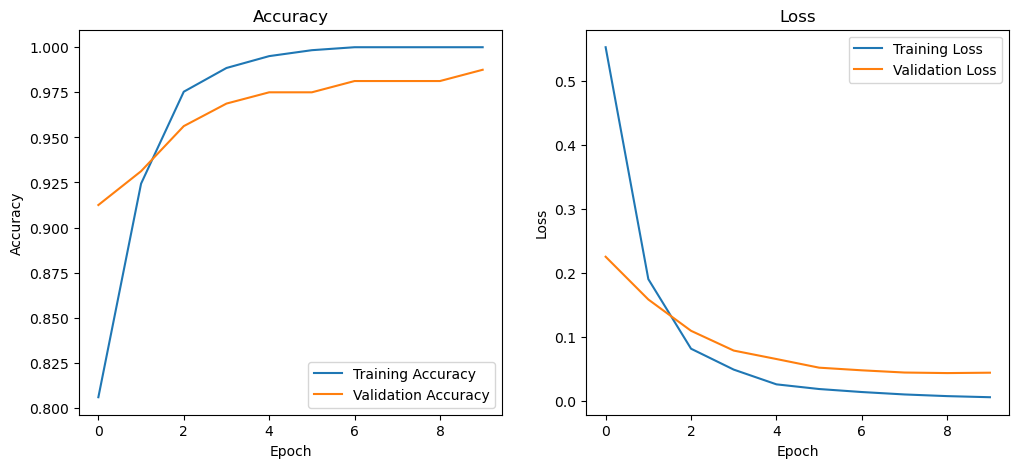

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9889 - loss: 0.0400
Test Accuracy: 0.99 Test Loss: 0.04


In [15]:
"""
Plot Accuracy & Loss for each Epoch
"""
plt.figure(figsize=(12, 5))

# Epoch vs Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"],     label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")

# Epoch vs Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"],     label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")

# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

plt.savefig(os.path.join(MODEL_NAME, "history.png"))
plt.show()

# Show Overall Performance
test_loss, test_acc = best_model.evaluate(validation_dataset)
print(f"Test Accuracy: {test_acc:.2f} Test Loss: {test_loss:.2f}")

In [16]:
"""
Save model and training history
"""
# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

with open(os.path.join(MODEL_NAME, "history.json"), "w") as file:
    json.dump(history.history, file)

best_model.save(os.path.join(MODEL_NAME, "model.keras"))

# Section 4 - Model Evaluation using a Confusion Matrix

In this section, we will use the best model from the previous section to create a Confusion Matrix.

In [17]:
"""
Load the model trained using the best hyperparameters
"""
best_model = load_model(os.path.join(MODEL_NAME, "model.keras"))

In [18]:
"""
Predict each image in the test dataset
"""
testing_dataset = image_dataset_from_directory(
    TESTING_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

# Apply ResNet50's image preprocessing
testing_dataset = testing_dataset.map(lambda x, y: (preprocess_input(x), y))

actual = []
predictions = []

for batch, labels in validation_dataset:
    results = best_model.predict(batch)  # Get raw predictions
    predicted_labels = (results > 0.5).astype(int).flatten()  # Convert probabilities to 0s and 1s
    predictions.extend(predicted_labels)  # Append predicted labels
    actual.extend(labels.numpy())  # Convert actual labels to list

print("Actual Labels:   ", actual)
print("Predicted Labels:", predictions)

Found 48 files belonging to 2 classes.


2025-03-22 04:59:27.250701: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Actual Labels:    [0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0]
Predicted Labels: [0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,

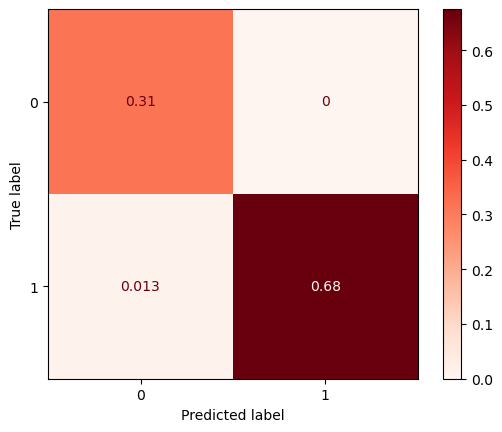

Accuracy: 0.9875


In [19]:
"""
Plot a Confusion Matrix of the test dataset predictions
"""
result = confusion_matrix(actual, predictions, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=result)
disp.plot(cmap="Reds")

# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

plt.savefig(os.path.join(MODEL_NAME, "confusionmatrix.png"))
plt.show()

with open(os.path.join(MODEL_NAME, "confusionmatrix.json"), "w") as file:
    json.dump(result.tolist(), file)

print(f"Accuracy: {result[0][0] + result[1][1]}")

# Section 5 - Model Evaluation using K-Fold Cross Validation

In this section, we will train the model K times with the best hyperparameters identified in section 2. The average accuracy of all folds will be calculated to determine if there is an overfit.

In [ ]:
"""
Load the saved GridSearch results
"""
filtered_results = pd.read_csv(os.path.join(MODEL_NAME, "gridsearch.csv"))

# Get the top-ranked result (rank_test_score == 1)
best_result = filtered_results[filtered_results["rank_test_score"] == 1].iloc[0]

# Extract optimizer and learning rate
best_optimizer = best_result["param_model__optimizer"]
best_learning_rate = best_result["param_model__learning_rate"]

best_optimizer, best_learning_rate

('Adam', 0.001)

In [21]:
"""
Load the training dataset
"""
dataset = image_dataset_from_directory(
    INPUT_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

# Apply ResNet50's image preprocessing
dataset = dataset.map(lambda x, y: (preprocess_input(x), y))

Found 768 files belonging to 2 classes.


In [22]:
"""
Prepare the data to be compatible with the K-Folds API
"""

# Function to convert TF dataset to NumPy arrays
def dataset_to_numpy(dataset):
    all_images, all_labels = [], []
    for images, labels in dataset:
        all_images.append(images.numpy())  # Convert images to NumPy
        all_labels.append(labels.numpy())  # Convert labels to NumPy
    return np.vstack(all_images), np.hstack(all_labels)

# Convert datasets for GridSearch compatibility
images, labels = dataset_to_numpy(dataset)

In [ ]:
"""
Perform K-Fold Cross-Validation
"""

kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

fold = 1
accuracies = []

for train_index, val_index in kf.split(images):
    print(f"Training on Fold {fold}/{K_FOLDS}...")

    # Split the data according to current fold
    training_images, validation_images = images[train_index], images[val_index]
    training_labels, validation_labels = labels[train_index], labels[val_index]

    # Define and compile model using the best hyperparameters
    model = create_model(
        optimizer=best_optimizer,
        learning_rate=best_learning_rate,
    )
    
    # Train the model using the fold
    history = model.fit(
        training_images,
        training_labels,
        validation_data=(
            validation_images,
            validation_labels
        ),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
    )
    
    # Calculate and keep track of the score
    scores = model.evaluate(validation_images, validation_labels, verbose=0)
    print(f"Fold {fold} Accuracy: {scores[1] * 100:.2f}%")

    accuracies.append(scores[1] * 100)
    fold += 1

Training on Fold 1/5...
Epoch 1/10


2025-03-22 05:00:48.405463: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8050 - loss: 0.5126   

2025-03-22 05:01:50.641443: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


20/20 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.8072 - loss: 0.5072 - val_accuracy: 0.9351 - val_loss: 0.2142
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 380ms/step - accuracy: 0.9480 - loss: 0.1636 - val_accuracy: 0.9481 - val_loss: 0.1320
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.9810 - loss: 0.0771 - val_accuracy: 0.9351 - val_loss: 0.1363
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.9830 - loss: 0.0510 - val_accuracy: 0.9610 - val_loss: 0.0867
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9986 - loss: 0.0226 - val_accuracy: 0.9805 - val_loss: 0.1059
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.9831 - loss: 0.0428 - val_accuracy: 0.9870 - val_loss: 0.0445
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - accuracy: 1.0000 - loss: 0.0110 - val_accuracy: 0.9935 - val_loss: 0.0305
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9870 - val_l

2025-03-22 05:03:09.071130: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.5933 - loss: 1.6353 - val_accuracy: 0.8052 - val_loss: 0.5194
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step - accuracy: 0.8937 - loss: 0.3085 - val_accuracy: 0.9156 - val_loss: 0.1947
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 344ms/step - accuracy: 0.9145 - loss: 0.1934 - val_accuracy: 0.9481 - val_loss: 0.1310
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - accuracy: 0.9594 - loss: 0.1226 - val_accuracy: 0.9610 - val_loss: 0.1091
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.9889 - loss: 0.0721 - val_accuracy: 0.9610 - val_loss: 0.0882
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 275ms/step - accuracy: 0.9975 - loss: 0.0449 - val_accuracy: 0.9870 - val_loss: 0.0659
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.9936 - loss: 0.0293 - val_accuracy: 0.9675 - val_loss: 0.0774
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9973 - loss: 0.0288 - val_accuracy: 0.9805 - val_lo

2025-03-22 05:05:04.390088: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6503 - loss: 1.4603 - val_accuracy: 0.8701 - val_loss: 0.4781
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 450ms/step - accuracy: 0.9206 - loss: 0.2332 - val_accuracy: 0.8701 - val_loss: 0.2924
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.9446 - loss: 0.1403 - val_accuracy: 0.8766 - val_loss: 0.2551
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.9618 - loss: 0.1099 - val_accuracy: 0.9156 - val_loss: 0.1781
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 311ms/step - accuracy: 0.9727 - loss: 0.0893 - val_accuracy: 0.9351 - val_loss: 0.1424
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.9862 - loss: 0.0502 - val_accuracy: 0.9545 - val_loss: 0.1259
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.9940 - loss: 0.0386 - val_accuracy: 0.9610 - val_loss: 0.0942
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.9957 - loss: 0.0238 - val_accuracy: 0.9740 - val_lo

2025-03-22 05:06:55.469249: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6216 - loss: 1.5950 - val_accuracy: 0.9216 - val_loss: 0.2224
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 526ms/step - accuracy: 0.8988 - loss: 0.2302 - val_accuracy: 0.9346 - val_loss: 0.1860
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 302ms/step - accuracy: 0.9533 - loss: 0.1482 - val_accuracy: 0.9608 - val_loss: 0.1359
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step - accuracy: 0.9540 - loss: 0.1133 - val_accuracy: 0.9608 - val_loss: 0.1258
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.9900 - loss: 0.0624 - val_accuracy: 0.9739 - val_loss: 0.0802
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.9735 - loss: 0.0761 - val_accuracy: 0.9673 - val_loss: 0.0695
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.9942 - loss: 0.0431 - val_accuracy: 0.9739 - val_loss: 0.0517
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.9986 - loss: 0.0278 - val_accuracy: 0.9739 - val_l

2025-03-22 05:08:39.281322: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6954 - loss: 1.0122 - val_accuracy: 0.8693 - val_loss: 0.3703
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 478ms/step - accuracy: 0.8770 - loss: 0.3119 - val_accuracy: 0.9150 - val_loss: 0.2513
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.9459 - loss: 0.1369 - val_accuracy: 0.9412 - val_loss: 0.1361
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.9823 - loss: 0.0877 - val_accuracy: 0.9542 - val_loss: 0.0942
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 324ms/step - accuracy: 0.9830 - loss: 0.0561 - val_accuracy: 0.9673 - val_loss: 0.0699
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.9910 - loss: 0.0397 - val_accuracy: 0.9739 - val_loss: 0.0608
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.9961 - loss: 0.0270 - val_accuracy: 0.9739 - val_loss: 0.0569
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 0.9804 - val_l

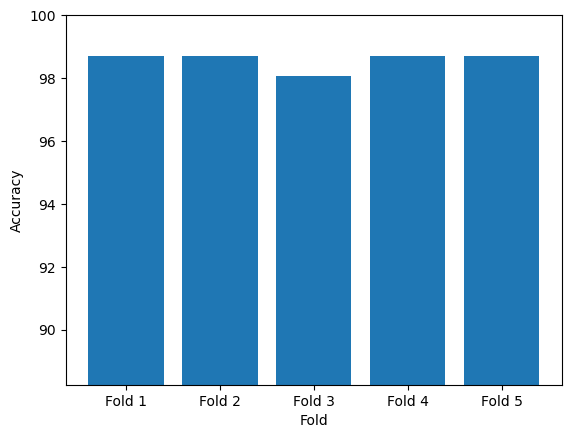

Average Accuracy: 98.57% ± 0.26%


In [24]:
"""
Plot the accuracy for each fold
"""

plt.bar([f"Fold {n}" for n in range(1, K_FOLDS + 1)], accuracies)

# Auto-rescale the bars
plt.ylim(
    min(accuracies) * 0.9,          # 0.9 to make the smallest bar still visible
    min(max(accuracies) * 1.1, 100) # 1.1 to make extra space above the  largest bar
)
plt.xlabel("Fold")
plt.ylabel("Accuracy")

# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

plt.savefig(os.path.join(MODEL_NAME, "kfold.png"))
plt.show()

print(f"Average Accuracy: {np.mean(accuracies):.2f}% ± {np.std(accuracies):.2f}%")

In [25]:
"""
Save K-Fold score
"""
# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

with open(os.path.join(MODEL_NAME, "kfold.json"), "w") as file:
    json.dump(accuracies, file)